# Data Preprocessing & Feature Engineering

### Import Libraries

In [64]:
# import json
import pickle
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

### Load Dataset

In [65]:
data_1 = Path('../data/car_price.csv').resolve()
data_2 = Path('../data/cardekho.csv').resolve()
df1 = pd.read_csv(data_1)
df2 = pd.read_csv(data_2)
print(f"Dataset Size : \ndf1 - {df1.shape}\ndf2 - {df2.shape}")

Dataset Size : 
df1 - (5512, 10)
df2 - (8128, 12)


## EDA

### EDA - Data 1

In [66]:
df1.isnull().sum()

Unnamed: 0             0
car_name               0
car_prices_in_rupee    0
kms_driven             0
fuel_type              0
transmission           0
ownership              0
manufacture            0
engine                 0
Seats                  0
dtype: int64

In [67]:
# splitting car name into brand and car
df1['brand'] = df1.car_name.apply(lambda x:x.split()[0])
df1['car'] = df1.car_name.apply(lambda x:x.split()[1])
df1.drop(['Unnamed: 0','car_name'],axis=1,inplace=True)

In [68]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   car_prices_in_rupee  5512 non-null   object
 1   kms_driven           5512 non-null   object
 2   fuel_type            5512 non-null   object
 3   transmission         5512 non-null   object
 4   ownership            5512 non-null   object
 5   manufacture          5512 non-null   int64 
 6   engine               5512 non-null   object
 7   Seats                5512 non-null   object
 8   brand                5512 non-null   object
 9   car                  5512 non-null   object
dtypes: int64(1), object(9)
memory usage: 430.8+ KB


In [69]:
# Function to change price type from str to float and handles different units like "Lakh" and "Crore"
def clean_price(price: str)-> float :
    """
    Performs the following:
    - If the price contains "Lakh", it multiplies the number by 100,000.
    - If the price contains "Crore", it multiplies the number by 10,000,000.
    - If no units are present, it simply returns the float after removing any commas.
    """
    value_terms = price.split()   # splitting price into number and units (eg: 10 Lakh ---> [10, 'Lakh'])
    return np.round(float(value_terms[0])*100000) if len(value_terms)>1 and value_terms[1].startswith("L") else \
    np.round(float(value_terms[0])*10000000) if len(value_terms)>1 and value_terms[1].startswith("C") else float(value_terms[0].replace(',',''))

# Function to change kms type from str to int
def clean_kms(km : str) -> int:
    return int(km.split()[0].replace(',',''))

# Data Cleaning
df1['price'] = df1.car_prices_in_rupee.apply(clean_price)
df1.drop(columns = 'car_prices_in_rupee',inplace = True)
df1.kms_driven = df1.kms_driven.apply(clean_kms)
df1.rename({'manufacture':'year'},axis = 1,inplace = True)  # Renames the column 'manufacture' to 'year' for better clarity 
df1.engine = df1.engine.apply(lambda x:int(x.split()[0]))   # Extracts the numeric part of the engine size 
df1.Seats = df1.Seats.apply(lambda x:int(x.split()[0]))     # Extracts the numeric part and converts it into an integer.

In [70]:
# Setting up owner ship level upto 3 
# All others (4th owner, 5th owner) is converted into 3rd owner
owner_levels = df1.ownership.value_counts().index
df1.loc[~df1.ownership.isin(owner_levels[0:2]),'ownership']='3rd owner'
df1.ownership.value_counts()

ownership
1st Owner    3736
2nd Owner    1314
3rd owner     462
Name: count, dtype: int64

In [71]:
# Print All Fuel types
print(df1.fuel_type.value_counts())

# Removing cng, lpg, electric .
fuel_types = df1.fuel_type.value_counts().index
df1.drop(df1[~df1.fuel_type.isin(fuel_types[0:2])].index,inplace=True)
print("\nAfter..\n",df1.fuel_type.value_counts())

fuel_type
Petrol      2967
Diesel      2423
Cng           80
Lpg           28
Electric      14
Name: count, dtype: int64

After..
 fuel_type
Petrol    2967
Diesel    2423
Name: count, dtype: int64


In [72]:
df1.describe(include='all')

,kms_driven,fuel_type,transmission,ownership,year,engine,Seats,brand,car,price
count,5390.000000,5390,5390,5390,5390.000000,5390.000000,5390.000000,5390,5390,5.390000e+03
unique,NaN,2,2,3,NaN,NaN,NaN,32,228,NaN
top,NaN,Petrol,Manual,1st Owner,NaN,NaN,NaN,Maruti,Swift,NaN
freq,NaN,2967,3854,3653,NaN,NaN,NaN,1309,386,NaN
mean,63113.105380,NaN,NaN,NaN,2015.456772,1534.082004,5.249351,NaN,NaN,1.178569e+06
std,41988.595046,NaN,NaN,NaN,3.922837,578.181249,0.718351,NaN,NaN,1.988032e+06
min,250.000000,NaN,NaN,NaN,1995.000000,0.000000,2.000000,NaN,NaN,3.500000e+04
25%,32945.250000,NaN,NaN,NaN,2013.000000,1197.000000,5.000000,NaN,NaN,3.200000e+05
50%,59000.000000,NaN,NaN,NaN,2016.000000,1396.000000,5.000000,NaN,NaN,5.530000e+05
75%,84211.750000,NaN,NaN,NaN,2018.000000,1950.000000,5.000000,NaN,NaN,1.050000e+06


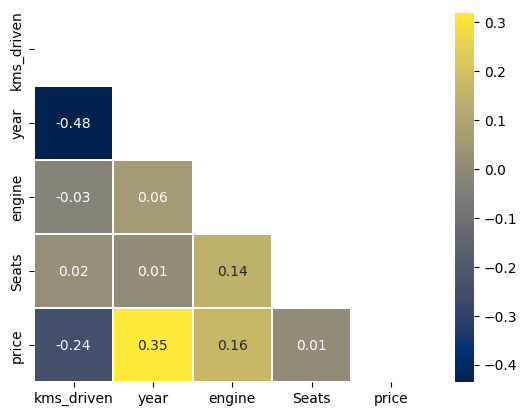

In [73]:
# Correlation matrix of features
corr = df1[df1.describe().columns].corr()
mask = np.triu(np.ones(corr.shape)).astype('bool')
sns.heatmap(corr,annot=True,linewidths=.2,robust=True,fmt='.2f',mask=mask,cmap='cividis');

### EDA - Data 2

In [74]:
# Splitting car name into brand and car
df2['brand'] = df2.name.apply(lambda x:x.split()[0])
df2['car'] = df2.name.apply(lambda x:x.split()[1])
df2.drop(columns=['mileage(km/ltr/kg)','seller_type','max_power','name'],inplace=True)
df2.head()

,year,selling_price,km_driven,fuel,transmission,owner,engine,seats,brand,car
0,2014,450000,145500,Diesel,Manual,First Owner,1248.0,5.0,Maruti,Swift
1,2014,370000,120000,Diesel,Manual,Second Owner,1498.0,5.0,Skoda,Rapid
2,2006,158000,140000,Petrol,Manual,Third Owner,1497.0,5.0,Honda,City
3,2010,225000,127000,Diesel,Manual,First Owner,1396.0,5.0,Hyundai,i20
4,2007,130000,120000,Petrol,Manual,First Owner,1298.0,5.0,Maruti,Swift


In [75]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           8128 non-null   int64  
 1   selling_price  8128 non-null   int64  
 2   km_driven      8128 non-null   int64  
 3   fuel           8128 non-null   object 
 4   transmission   8128 non-null   object 
 5   owner          8128 non-null   object 
 6   engine         7907 non-null   float64
 7   seats          7907 non-null   float64
 8   brand          8128 non-null   object 
 9   car            8128 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 635.1+ KB


In [76]:
df2.describe(include='all')

,year,selling_price,km_driven,fuel,transmission,owner,engine,seats,brand,car
count,8128.000000,8.128000e+03,8.128000e+03,8128,8128,8128,7907.000000,7907.000000,8128,8128
unique,NaN,NaN,NaN,4,2,5,NaN,NaN,32,207
top,NaN,NaN,NaN,Diesel,Manual,First Owner,NaN,NaN,Maruti,Swift
freq,NaN,NaN,NaN,4402,7078,5289,NaN,NaN,2448,782
mean,2013.804011,6.382718e+05,6.981951e+04,NaN,NaN,NaN,1458.625016,5.416719,NaN,NaN
std,4.044249,8.062534e+05,5.655055e+04,NaN,NaN,NaN,503.916303,0.959588,NaN,NaN
min,1983.000000,2.999900e+04,1.000000e+00,NaN,NaN,NaN,624.000000,2.000000,NaN,NaN
25%,2011.000000,2.549990e+05,3.500000e+04,NaN,NaN,NaN,1197.000000,5.000000,NaN,NaN
50%,2015.000000,4.500000e+05,6.000000e+04,NaN,NaN,NaN,1248.000000,5.000000,NaN,NaN
75%,2017.000000,6.750000e+05,9.800000e+04,NaN,NaN,NaN,1582.000000,5.000000,NaN,NaN


In [77]:
df2.owner.value_counts()

owner
First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: count, dtype: int64

In [78]:
# Setting up owner ship level upto 3  | All others (4th owner, 5th owner) is converted into 3rd owner
df2.drop(df2[df2.owner.str.startswith('Test')].index,inplace=True)
df2.loc[df2[df2.owner.str.startswith('Fourth')].index,'owner']='Third Owner'
df2.owner.value_counts()

owner
First Owner     5289
Second Owner    2105
Third Owner      729
Name: count, dtype: int64

In [79]:
# Removing LPG and CNG vehicles
print(df2.fuel.value_counts())
df2.drop(df2[df2.fuel.isin(['LPG','CNG'])].index,inplace=True)
print("\nAfter...\n",df2.fuel.value_counts())

fuel
Diesel    4401
Petrol    3627
CNG         57
LPG         38
Name: count, dtype: int64

After...
 fuel
Diesel    4401
Petrol    3627
Name: count, dtype: int64


In [80]:
df1.columns

Index(['kms_driven', 'fuel_type', 'transmission', 'ownership', 'year',
       'engine', 'Seats', 'brand', 'car', 'price'],
      dtype='object')

### Merge Data

In [81]:
df2 = df2[['km_driven','fuel','transmission','owner','year','engine','seats','brand','car','selling_price']]  # Rearranging column order
# Configuring columns names of both dataframe exactly same
mapper = {i:j for i,j in zip(df2,df1)}
df2.rename(mapper,axis=1,inplace=True)
df = pd.concat([df1,df2],axis=0).reset_index(drop=True)
df = df[['brand','car','year','ownership','kms_driven','fuel_type','transmission','Seats','engine','price']]

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13418 entries, 0 to 13417
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         13418 non-null  object 
 1   car           13418 non-null  object 
 2   year          13418 non-null  int64  
 3   ownership     13418 non-null  object 
 4   kms_driven    13418 non-null  int64  
 5   fuel_type     13418 non-null  object 
 6   transmission  13418 non-null  object 
 7   Seats         13204 non-null  float64
 8   engine        13204 non-null  float64
 9   price         13418 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 1.0+ MB


In [83]:
df.describe(include='all')

,brand,car,year,ownership,kms_driven,fuel_type,transmission,Seats,engine,price
count,13418,13418,13418.000000,13418,1.341800e+04,13418,13418,13204.000000,13204.000000,1.341800e+04
unique,37,260,NaN,6,NaN,2,2,NaN,NaN,NaN
top,Maruti,Swift,NaN,First Owner,NaN,Diesel,Manual,NaN,NaN,NaN
freq,3687,1168,NaN,5238,NaN,6824,10836,NaN,NaN,NaN
mean,NaN,NaN,2014.474810,NaN,6.709781e+04,NaN,NaN,5.351257,1491.965844,8.565784e+05
std,NaN,NaN,4.068028,NaN,5.136522e+04,NaN,NaN,0.875620,537.066453,1.429177e+06
min,NaN,NaN,1983.000000,NaN,2.500000e+02,NaN,NaN,2.000000,0.000000,2.999900e+04
25%,NaN,NaN,2012.000000,NaN,3.400000e+04,NaN,NaN,5.000000,1197.000000,2.820000e+05
50%,NaN,NaN,2015.000000,NaN,6.000000e+04,NaN,NaN,5.000000,1299.000000,4.935000e+05
75%,NaN,NaN,2017.000000,NaN,9.000000e+04,NaN,NaN,5.000000,1598.000000,7.700000e+05


In [84]:
df.ownership.value_counts()

ownership
First Owner     5238
1st Owner       3653
Second Owner    2073
2nd Owner       1287
Third Owner      717
3rd owner        450
Name: count, dtype: int64

In [85]:
# Modifying ownership details ion same format for both data
df.loc[df[df.ownership.str.startswith('1')].index,'ownership']='First Owner'
df.loc[df[df.ownership.str.startswith('2')].index,'ownership']='Second Owner'
df.loc[df[df.ownership.str.startswith('3')].index,'ownership']='Third Owner'
df.ownership.value_counts()

ownership
First Owner     8891
Second Owner    3360
Third Owner     1167
Name: count, dtype: int64

In [86]:
# Removing drupicate entries
print('duplicates:',df.duplicated().sum())
df.drop_duplicates(inplace=True)
print('after cleaning :',df.duplicated().sum())

duplicates: 1310
after cleaning : 0


In [87]:
# changing year column to number of years
import datetime
year=datetime.date.today().year
df['age'] = df.year.apply(lambda x:year-x)

In [88]:
#filtering out most frequent Brands (removing outliers)
freq_brands = df.brand.value_counts()[~(df.brand.value_counts()<20)].index
df = df[df.brand.isin(freq_brands)]

In [89]:
#car distribution in price range
print("Car Distributions")
pd.cut(df.price,bins=[1e4,1e5,5e5,1e6,15e5,2e6,25e5,3e6,1e7],labels=['under 1 lakh','1 lakk - 5 lakk','5 lakh - 10 lak'\
,'10 lakh - 15 lakh','15 lakh - 20 lakh','20 lakh - 25 lakh','25 lakh - 30 lakh','more tha 30 lakh']).value_counts()

Car Distributions


price
1 lakk - 5 lakk      6065
5 lakh - 10 lak      3688
10 lakh - 15 lakh     658
under 1 lakh          493
more tha 30 lakh      433
15 lakh - 20 lakh     382
20 lakh - 25 lakh     130
25 lakh - 30 lakh     127
Name: count, dtype: int64

In [90]:
# majority of the data lies under 10 lakhs
car_under_10lakh = df[df.price<1e6].car.value_counts().head(100)
car_above_10_lakh = df[df.price>1e6].car.value_counts().head(100)

#filtering cars under 10 lakhs only
cars_10lakh=[]
for i in car_under_10lakh.index:
    # if the car also came under 'above 10 lakh' ; compare counts
    if i in car_above_10_lakh.index:
        if car_under_10lakh[i]>car_above_10_lakh[i]:   # consider if majority cars fall under 10 lakh
            cars_10lakh.append(i)
    else:
        cars_10lakh.append(i)
print("Number of car models under 10 lakh :",len(cars_10lakh))

Number of car models under 10 lakh : 98


In [91]:
# Filtering out only the cars having price under 10 lakhs
df = df[df.car.isin(cars_10lakh)]
df = df[df.brand.isin(df.brand.value_counts()[:-3].index)]  # Removing brands with less entries (outlier)
df = df[~(df.price>2e6)] # Removing cars with price great than 2e6 (outlier)

In [92]:
df.brand.value_counts()

brand
Maruti        3337
Hyundai       2148
Mahindra       938
Honda          821
Tata           806
Ford           479
Toyota         435
Renault        345
Volkswagen     308
Chevrolet      274
Skoda          155
Nissan         121
Name: count, dtype: int64

#### Car Price Distribution

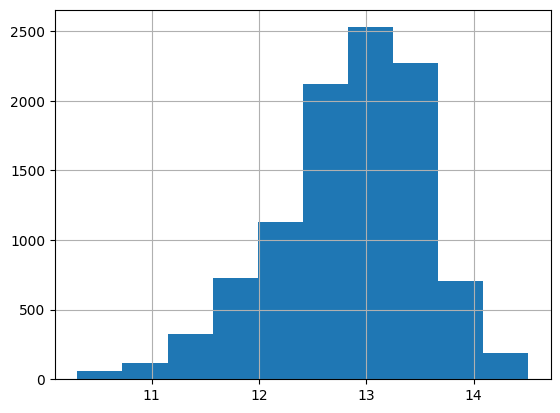

In [93]:
np.log(df.price).hist(bins=10);

In [94]:
# filtering less occurent cars
df = df[~df.car.isin(['Jetta','New','Altroz','Pulse','Lodgy','S-Presso','S-Cross','Grand','Esteem','Getz',\
              'Optra','Freestyle','Accord','BR-V','Mobilio','Superb','Enjoy'])]

# Removing outliers
df = df[df.car.isin(df.car.value_counts()[:-9].index)]
df = df[df.kms_driven<400000]
df.shape

(9348, 11)

#### Data Transformation Analysis

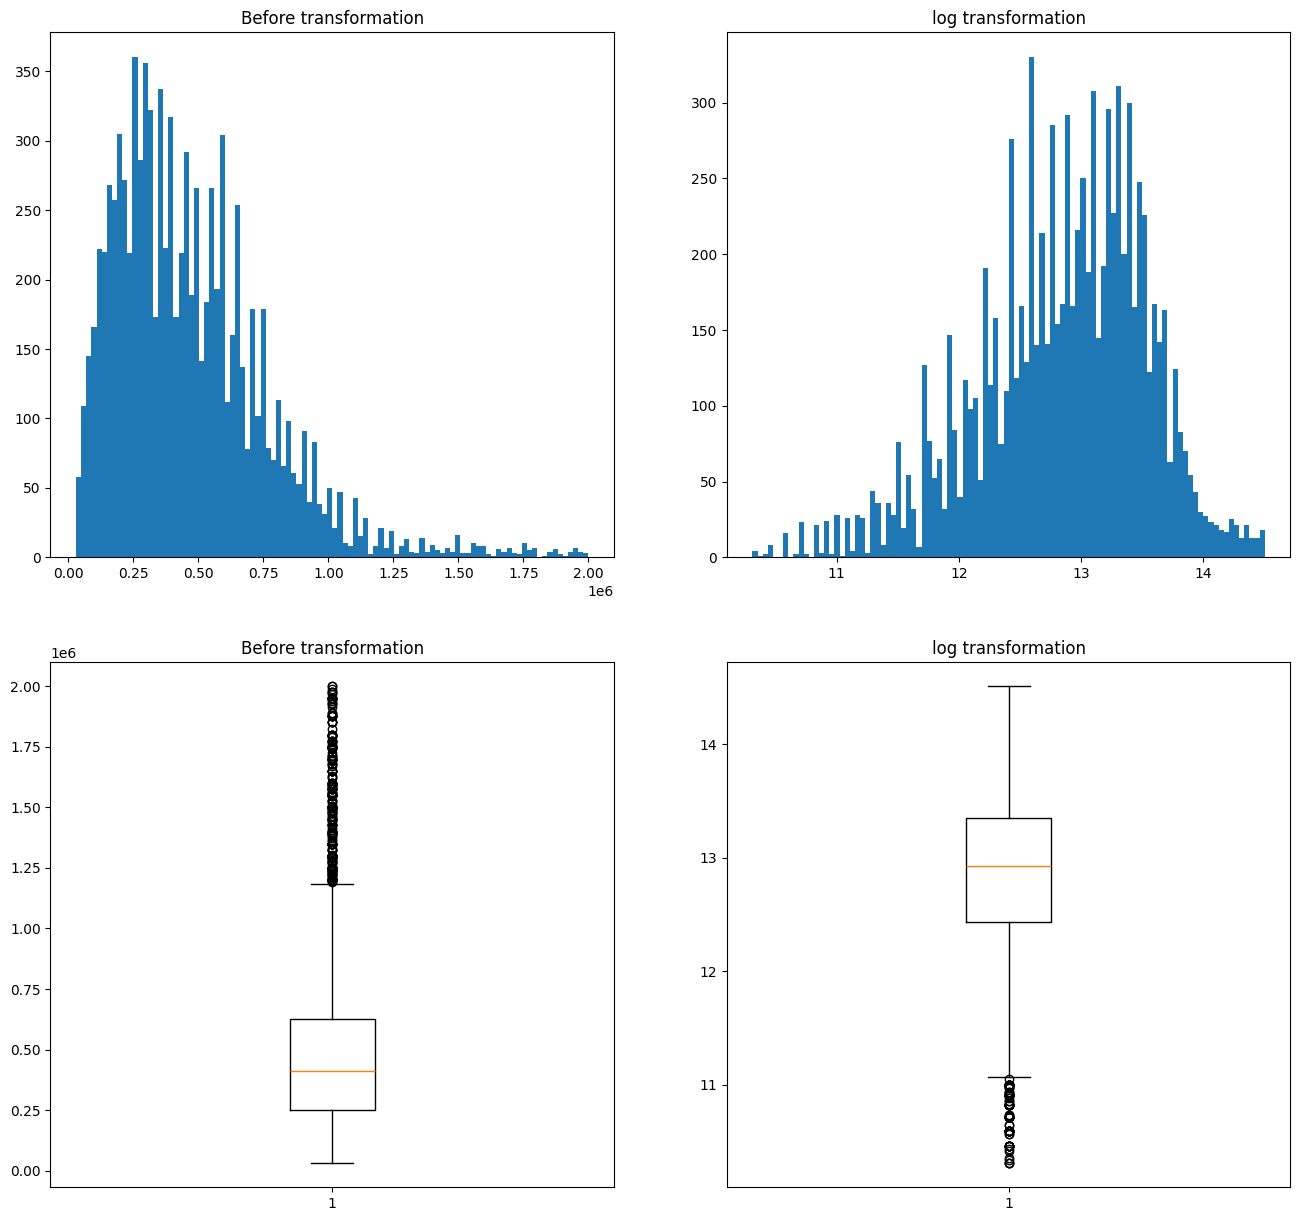

In [95]:
fig,ax=plt.subplots(2,2,figsize=(16,15))
ax[0,0].hist(df.price,bins=100)
ax[0,0].set_title('Before transformation')
ax[0,1].hist(np.log(df.price),bins=100)
ax[0,1].set_title('log transformation')
ax[1,0].boxplot(df.price)
ax[1,0].set_title('Before transformation')
ax[1,1].boxplot(np.log(df.price))
ax[1,1].set_title('log transformation')
plt.show()

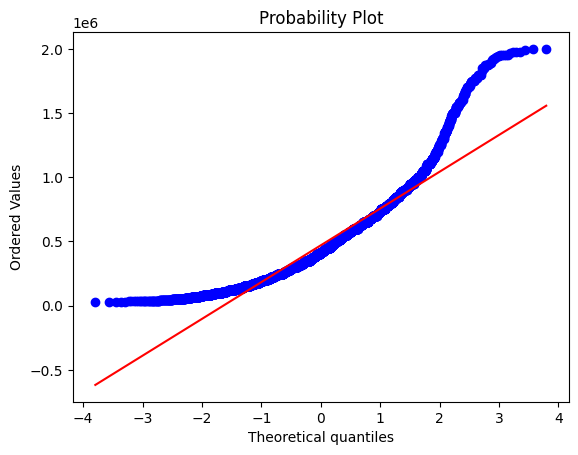

In [96]:
from scipy import stats as stat
stat.probplot(df['price'],dist='norm',plot=plt);

#### Fuel Type Distribution

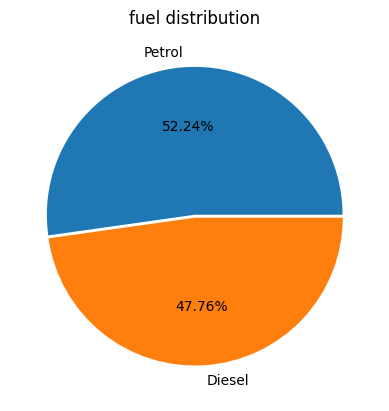

In [97]:
plt.pie(df.fuel_type.value_counts(),autopct='%.2f%%',labels=df.fuel_type.value_counts().index,explode=[0.01,0.01])
plt.title('fuel distribution')
plt.show();

#### Ownership Distribution

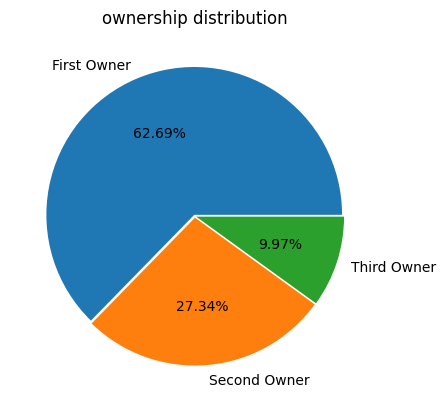

In [98]:
plt.pie(df.ownership.value_counts(),autopct='%.2f%%',labels=df.ownership.value_counts().index,explode=[0.01,0.01,0.01])
plt.title('ownership distribution')
plt.show();

#### Transmission Distribution

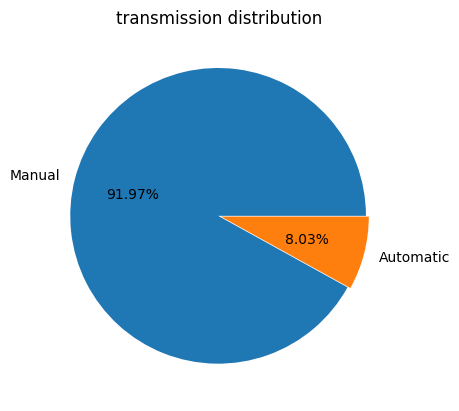

In [99]:
plt.pie(df.transmission.value_counts(),autopct='%.2f%%',labels=df.transmission.value_counts().index,explode=[0.01,0.01])
plt.title('transmission distribution')
plt.show();

#### Price - Engine CC relation

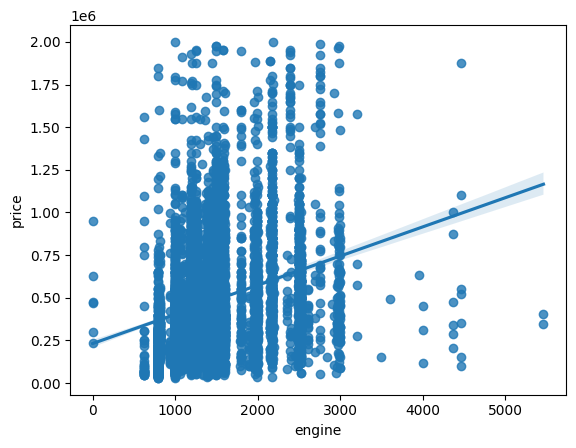

In [100]:
sns.regplot(df,y='price',x='engine');

#### Price - Car Age Correlation

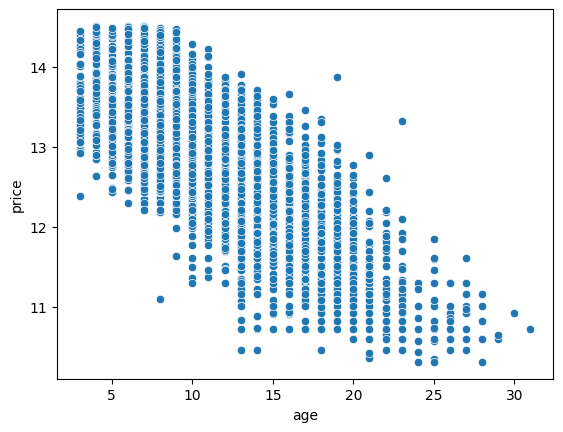

In [101]:
sns.scatterplot(x=df.age,y=np.log(df.price));

<Axes: xlabel='age', ylabel='price'>

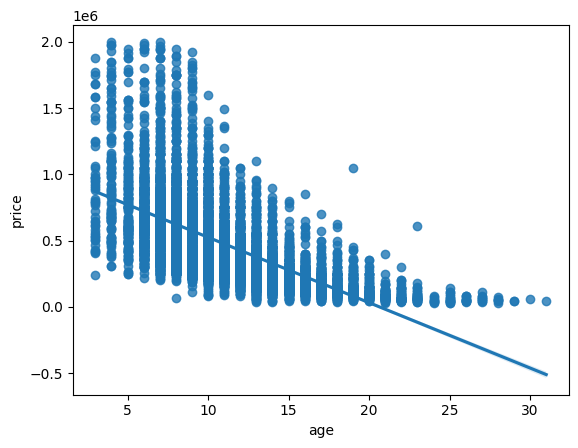

In [102]:
sns.regplot(df,y='price',x='age')

#### Car - Kms Driven Relation

<Axes: xlabel='kms_driven', ylabel='price'>

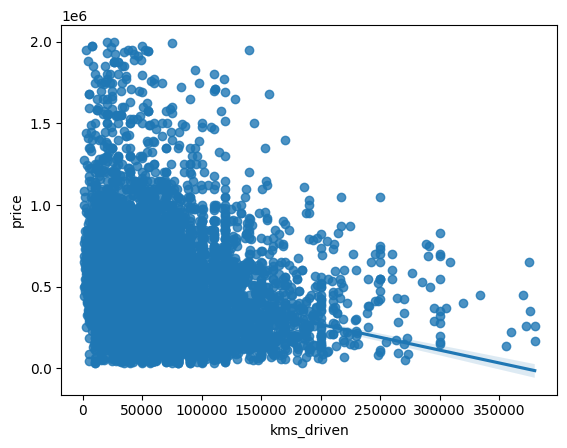

In [103]:
sns.regplot(df,y='price',x='kms_driven')

#### Saving Processed Dataset

In [104]:
df.drop(columns=['year','Seats','engine','transmission'],inplace=True)  # Removing less dependemt features
df = df.reset_index(drop=True)
df.to_csv('processed_data.csv',index=False)

-----------------------